In [1]:
!date

Fri Sep 29 17:44:46 EDT 2023


# Grab lake contours bigger than 5 degrees - no time tracking
## Make distance and direction field, lake by lake (time by time)
#### from all available datafiles, their names end in distance.nc

------------


In [41]:
from shapely import geometry
import matplotlib.pyplot as plt
from matplotlib import cm
import numpy as np
import fiona             # a read-write library for shapefiles
import os         
#from descartes.patch import PolygonPatch

from shapely.geometry import Point
import pyproj
geodesic = pyproj.Geod(ellps='WGS84')

from glob import glob
import xarray as xr
#import dask.array as da

import pandas as pd
import geopandas as gp
from datetime import datetime

In [72]:
# Make directories for the outputs 

for ifile in range( len(files) ):  
    file = files[ifile] # replace with a loop to do all the MERRA2_MINIMAL data files
    print(file)
    
# folder to put results in: make it if it doesn't exist
    path = file[0:67]+'/TIMELEVELS/'
    os.makedirs(path, exist_ok=True)
    datestr = file[67:80]
    pathpath = file[0:67]+'/TIMELEVELS/'+datestr+'/'
    os.makedirs(pathpath, exist_ok=True)
    print(pathpath)

/Users/brianmapes/Box/VaporLakes/data/LAKEBYLAKE/MERRA2_2D/MINIMAL/2015_03_21_09_lat5p130N.M2_min2D_distance.nc
/Users/brianmapes/Box/VaporLakes/data/LAKEBYLAKE/MERRA2_2D/MINIMAL//TIMELEVELS/2015_03_21_09/
/Users/brianmapes/Box/VaporLakes/data/LAKEBYLAKE/MERRA2_2D/MINIMAL/2017_05_06_18_lat1p979S.M2_min2D_distance.nc
/Users/brianmapes/Box/VaporLakes/data/LAKEBYLAKE/MERRA2_2D/MINIMAL//TIMELEVELS/2017_05_06_18/
/Users/brianmapes/Box/VaporLakes/data/LAKEBYLAKE/MERRA2_2D/MINIMAL/2015_04_30_02_lat0p276N.M2_min2D_distance.nc
/Users/brianmapes/Box/VaporLakes/data/LAKEBYLAKE/MERRA2_2D/MINIMAL//TIMELEVELS/2015_04_30_02/
/Users/brianmapes/Box/VaporLakes/data/LAKEBYLAKE/MERRA2_2D/MINIMAL/2014_05_11_18_lat2p131S.M2_min2D_distance.nc
/Users/brianmapes/Box/VaporLakes/data/LAKEBYLAKE/MERRA2_2D/MINIMAL//TIMELEVELS/2014_05_11_18/
/Users/brianmapes/Box/VaporLakes/data/LAKEBYLAKE/MERRA2_2D/MINIMAL/2018_03_19_12_lat9p318S.M2_min2D_distance.nc
/Users/brianmapes/Box/VaporLakes/data/LAKEBYLAKE/MERRA2_2D/MINIM

In [42]:
files = glob('/Users/brianmapes/Box/VaporLakes/data/LAKEBYLAKE/MERRA2_2D/MINIMAL/*distance.nc')

In [70]:
file = files[0]
path = file[0:67]+"TIMELEVELS/"
os.makedirs(path, exist_ok=True)
path

'/Users/brianmapes/Box/VaporLakes/data/LAKEBYLAKE/MERRA2_2D/MINIMAL/TIMELEVELS/'

In [43]:
# CRS warnings are annoying below, I might suppress all just for readability

import warnings
warnings.filterwarnings("ignore")

# A function to return a GeoDataFrame of polygons 

In [44]:
# loop over contour collections (and polygons in each collection)
# store in polylist  
def gdf_from_contours(lon,lat,tqv,conlevel):
    
    levels = [conlevel, 9e9]
    cs = plt.contourf(lon,lat,tqv,levels)
# create lookup table for levels
    lvl_lookup = dict(zip(cs.collections, cs.levels))
    
    zvalues, polylist  = [], []
#    i=0
    for col in cs.collections:
        z=lvl_lookup[col] # the value of this level
        for contour_path in col.get_paths():
#        print('contour path: ',i); i = i+1
        # create the polygon for this level
            for ncp,cp in enumerate(contour_path.to_polygons()):
#            print('   ncp: ', ncp)
                lons = np.array(cp)[:,0]
                lats = np.array(cp)[:,1]
                new_shape = geometry.Polygon([(i[0], i[1]) for i in zip(lons,lats)])            
                if ncp == 0:
                    poly = new_shape # first shape
                else:
                    poly = poly.difference(new_shape) # Remove the holes

            polylist.append(poly)
            zvalues.append(z)
        
        gdf = gp.GeoDataFrame(geometry=polylist)
        gdf['tqv_values']=zvalues
        gdf['perimeter']=gdf.length
        gdf['area']=gdf.area
        gdf['centroidlat']=gdf.centroid.y
        gdf['centroidlon']=gdf.centroid.x
        gdf['centriod_is_inside']= gdf.contains(gdf.centroid)
        gdf['maxlon']=gdf.bounds.maxx
        gdf['minlon']=gdf.bounds.minx
        gdf['maxlat']=gdf.bounds.maxy
        gdf['minlat']=gdf.bounds.miny

        return(gdf)

------------

# Open each dataset in xarray, and loop over all times in it

In [45]:
MINSIZE = 5 # square degrees, smallest area lake (closed contour at an instant) to process 

/Users/brianmapes/Box/VaporLakes/data/LAKEBYLAKE/MERRA2_2D/MINIMAL/2015_03_21_09_lat5p130N.M2_min2D_distance.nc
/Users/brianmapes/Box/VaporLakes/data/LAKEBYLAKE/MERRA2_2D/MINIMAL/2017_05_06_18_lat1p979S.M2_min2D_distance.nc
/Users/brianmapes/Box/VaporLakes/data/LAKEBYLAKE/MERRA2_2D/MINIMAL/2015_04_30_02_lat0p276N.M2_min2D_distance.nc
/Users/brianmapes/Box/VaporLakes/data/LAKEBYLAKE/MERRA2_2D/MINIMAL/2014_05_11_18_lat2p131S.M2_min2D_distance.nc
/Users/brianmapes/Box/VaporLakes/data/LAKEBYLAKE/MERRA2_2D/MINIMAL/2018_03_19_12_lat9p318S.M2_min2D_distance.nc
/Users/brianmapes/Box/VaporLakes/data/LAKEBYLAKE/MERRA2_2D/MINIMAL/2014_04_17_06_lat6p223S.M2_min2D_distance.nc
/Users/brianmapes/Box/VaporLakes/data/LAKEBYLAKE/MERRA2_2D/MINIMAL/2017_05_06_20_lat0p918N.M2_min2D_distance.nc
/Users/brianmapes/Box/VaporLakes/data/LAKEBYLAKE/MERRA2_2D/MINIMAL/2014_05_11_15_lat4p404N.M2_min2D_distance.nc
/Users/brianmapes/Box/VaporLakes/data/LAKEBYLAKE/MERRA2_2D/MINIMAL/2015_09_17_21_lat3p507N.M2_min2D_dist

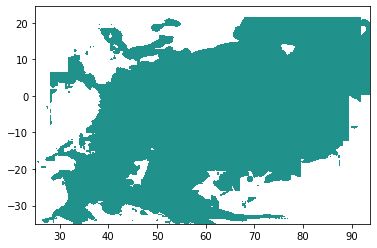

In [48]:
all_gdflakes = [] # collect them all in one big index set 

for ifile in range( len(files) ):  
    file = files[ifile] # replace with a loop to do all the MERRA2_MINIMAL data files
    print(file)
    
# folder to put results in: make it if it doesn't exist
    path = file[0:67]+"/TIMELEVELS/
    os.makedirs(path, exist_ok=True)
    datestr = file[67:80]
    pathpath = file[0:67]+/TIMELEVELS/+datestr+'/'
    os.makedirs(pathpath, exist_ok=True)

    bigds = xr.open_dataset(file)
    
    # Make an array of Points that are the gridpoints of MERRA2 in this file
    lat2d = bigds.lat.values[:,None]   + bigds.lon.values*0
    lon2d = bigds.lat.values[:,None]*0 + bigds.lon.values
    points = gp.GeoSeries( [Point(x, y) for x, y in zip(lon2d.ravel(),lat2d.ravel()) ] )\
            .set_crs(epsg = "4326", inplace = True)
     
# TIME LOOP OVER ALL TIMES: SLICE OFF ds DATASET - 2D ONLY
    for itime in range(len(bigds.time)): 
        ds = bigds.isel(time=itime).drop_vars(['distance','dir_from_centroid'])
        gdf = gdf_from_contours(ds.lon,ds.lat,ds.tqv, 55.)
    
        # Screen for "LAKES" inbounds and big enough (>5 square degrees) 
        inbounds = \
            (gdf.minlon > ds.lon.min().values) & (gdf.maxlon < ds.lon.max().values) & \
            (gdf.minlat > ds.lat.min().values) & (gdf.maxlat < ds.lat.max().values)
        gdflakes = gdf[ (inbounds == True) & (gdf.area > MINSIZE) ].copy().reindex()
    
# Now loop over all those lakes, making a distance field for each lake
        i=0 # counter for lakes at this time
        for lake in gdflakes.itertuples():
# Compute distance field from perimiter:
            dist = points.distance(lake.geometry.boundary).values.reshape(len(ds.lat),len(ds.lon))
            isin = points.within(lake.geometry).values.reshape(len(ds.lat),len(ds.lon))
            dist *= (-2)*(isin-0.5)  # make SIGNED distance from boundary, positive is exterior 

# Direction to centroid of WHOLE LAKE at this time
            centlon = lake.centroidlon
            centlat = lake.centroidlat 
# use j in explicit loop over gridpoints, since geodesic takes scalar only. Inelegant but works. 
            dir_to = []
            for j in range(len(lon2d.ravel())): 
                fwd_az,back_az,d = geodesic.inv(lon2d.ravel()[j], lat2d.ravel()[j], [centlon], [centlat])
                dir_to.append(fwd_az+180)
                
            dist_to = np.array(dist).reshape(len(ds.lat),len(ds.lon))
            dir_to = np.array(dir_to).reshape(len(ds.lat),len(ds.lon))

            command = "ds = ds.assign(distance"+str(i)+"=(['lat','lon'],dist))"
            exec(command)
            command = "ds = ds.assign(dir_to"+str(i)+"=(['lat','lon'],dir_to))"
            exec(command)
            i += 1 
            
            # write geojson of lakes at this time into one file -- no need really 
            # keeping all_gdflakes so that can be used later 
            #with open(file[:-2]+str(itime)+'lakes_contours.geojson', 'w') as f:
            #    f.write(gdflakes.to_json())
            #    f.close()
            
## SHOULD REALLY PUT THESE IN FOLDERS, BUT EASY IS JUST MAKE A FILENAME FOR NOW TO SEE IF IT WORKS 
#            ds.to_netcdf(file[:-2]+str(itime)+'_distdirs.nc')
# here is folder version with pathpath (datestr is both subfolder name and stub of filename)

            ds.to_netcdf(pathpath+datestr+'_time'str(itime)+'_distdirs.nc')
            ds.close()
                     
        all_gdflakes.append(gdflakes) # giant list of all lakes at all times in all files 

In [52]:
all_laks = pd.concat(all_gdflakes)

In [55]:
all_laks.describe()

,tqv_values,perimeter,area,centroidlat,centroidlon,maxlon,minlon,maxlat,minlat
count,29417.0,29417.000000,29417.000000,29417.000000,29417.000000,29417.000000,29417.000000,29417.000000,29417.000000
mean,55.0,28.081424,27.844157,-5.361489,56.894265,61.261063,52.743141,-2.268198,-8.489342
std,0.0,21.090498,30.958883,7.687699,12.499421,12.987158,12.403068,7.839770,8.003873
min,55.0,8.102051,5.000009,-33.403692,30.256016,31.541678,28.571819,-32.138882,-34.966376
25%,55.0,13.577415,8.061074,-10.127988,46.418777,51.286014,40.992584,-6.836725,-13.615205
50%,55.0,20.612550,16.017701,-6.037645,54.729713,59.653039,50.839962,-3.106900,-9.218296
75%,55.0,34.897611,33.864397,0.118020,66.958156,71.487416,62.208798,3.705710,-3.314814
max,55.0,184.735459,309.775824,17.584828,89.906100,92.877766,86.835776,21.479756,16.231698


In [56]:
# write geojson of lakes at this time into one file -- no need really 

with open('/Users/brianmapes/Box/VaporLakes/data/LAKEBYLAKE/MERRA2_2D/MINIMAL/AllLakeContours_2014-2018.geojson', 'w') as f:
    f.write(all_laks.to_json())

f.close()
 